# **Cementos Argos – Pronóstico de Demanda**
---
**Autor:** Juan Felipe Quinto


## **1. Carga y preparación de datos**

In [ ]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


DATA_PATH = "LAB_ML\Prediccion_de_demanda\raw_data\dataset_demand_acumulate.csv"
df = pd.read_csv(DATA_PATH)


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year_month  64 non-null     object 
 1   Demand      64 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [29]:
df.head()

,year_month,Demand
0,2017-01,1211.009490
1,2017-02,1660.584649
2,2017-03,3182.587014
3,2017-04,3506.515270
4,2017-05,4554.082280


In [30]:
df = df.sort_values("year_month").reset_index(drop=True)

In [31]:
print("Primeras fechas:", df["year_month"].iloc[0], df["year_month"].iloc[1])

Primeras fechas: 2017-01 2017-02


In [32]:
print("ultimas fechas:",df['year_month'].iloc[-2],df['year_month'].iloc[-1])

ultimas fechas: 2022-03 2022-04


In [33]:
df["fecha"] = pd.to_datetime(df["year_month"], format="%Y-%m")

# Ponemos esa columna como índice
df = df.set_index("fecha").sort_index()
df = df.drop(columns=["year_month"])   # Nos quedmos con 'Demand' y el índice


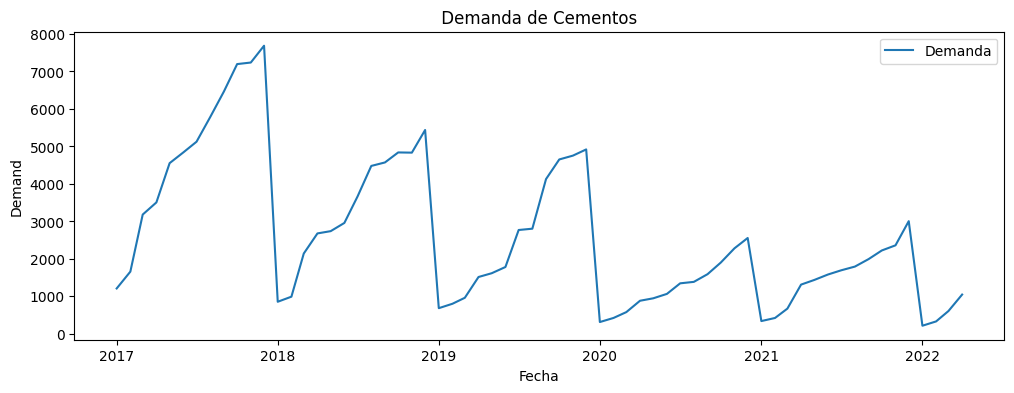

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot( df["Demand"], label="Demanda")
plt.title(" Demanda de Cementos ")
plt.xlabel("Fecha")
plt.ylabel("Demand")
plt.legend()

In [35]:
print("Primeras filas de df con índice datetime:")
print(df.head(), "\n")
print("Últimas filas de df con índice datetime:")
print(df.tail(), "\n")

Primeras filas de df con índice datetime:
                 Demand
fecha                  
2017-01-01  1211.009490
2017-02-01  1660.584649
2017-03-01  3182.587014
2017-04-01  3506.515270
2017-05-01  4554.082280 

Últimas filas de df con índice datetime:
                 Demand
fecha                  
2021-12-01  3006.311107
2022-01-01   217.314949
2022-02-01   332.062614
2022-03-01   609.119726
2022-04-01  1048.486287 



---

## **2.Train / Valid**

In [36]:
# 3) Dividimos:
#    - Train: hasta el 2021-12-01
#    - Valid: desde 2022-01-01 hasta 2022-04-01

train = df.loc[: "2021-12-01"].copy()
valid = df.loc["2022-01-01": "2022-04-01"].copy()

# Informamos los tamaños y rangos de fecha
print(f"Train: {train.shape[0]} registros, desde {train.index.min().date()} hasta {train.index.max().date()}")
print(f"Valid: {valid.shape[0]} registros, desde {valid.index.min().date()} hasta {valid.index.max().date()}")

Train: 60 registros, desde 2017-01-01 hasta 2021-12-01
Valid: 4 registros, desde 2022-01-01 hasta 2022-04-01


---

# **3. EDA - Train Data**

## **3.1 Gráfica de la serie completa**

Ya habíamos visto una gráfica general, pero repitamos con algo de detalle sobre los 60 meses de entrenamiento. Esto nos ayudará a notar picos, caídas y patrones cíclicos.

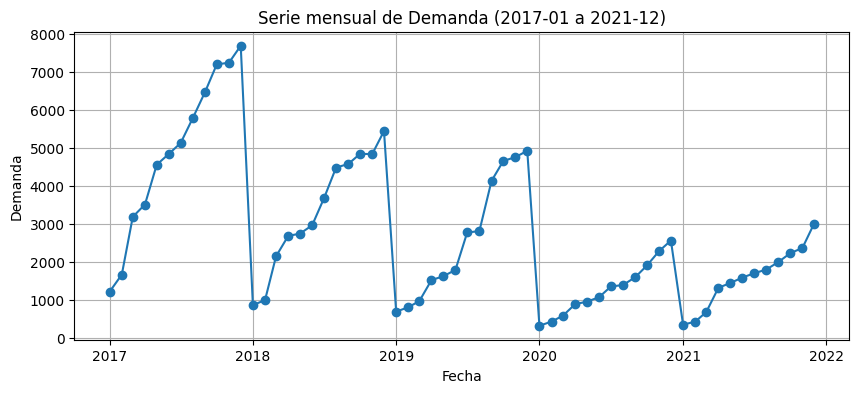

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train.index, train["Demand"], marker="o", linestyle="-")
plt.title("Serie mensual de Demanda (2017-01 a 2021-12)")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.grid(True)
plt.show()


**ANALISIS Gráfica de la serie (2017-01 - 2021-12)**

**Patrón general:** cada año la demanda arranca muy baja en enero/febrero, sube de forma relativamente constante y alcanza un pico máximo hacia diciembre. Luego, de forma abrupta, “resetea” a valores bajos al comienzo del año siguiente.

**Estacionalidad clara:** ese repunte año a año y el “colapso” en enero/febrero (caída brusca) se repite de manera casi idéntica en cada uno de los cinco años que tenemos en el train.

**Tendencia de largo plazo:** de 2017 a 2018 el pico anual crece hasta alrededor de 7.600–7.700; a partir de 2019 vemos que los máximos empiezan a bajar (en 2019 el máximo ronda 4.900–5.000, y en 2020 el máximo cae a ~2.500–2.600). Así, la serie tiene dos componentes principales:


  1. Tendencia descendente de los máximos año a año (hasta 2021, donde alcanza ~3000, superior al año anterior).
  2. Estacionalidad de periodo 12 meses, muy marcada (pico en fin de año, valle a comienzo de año).

## **3.2 Estadísticas descriptivas y distribuciones**

Obtener estadísticas básicas de la Demanda en el periodo de entrenamiento:

Estadísticas descriptivas de la Demanda (train):
count      60.00
mean     2736.60
std      1930.02
min       315.53
25%      1288.52
50%      2183.94
75%      4498.46
max      7686.31
Name: Demand, dtype: float64


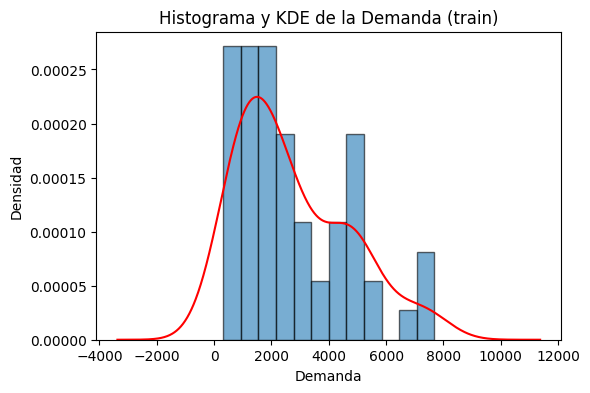

In [38]:
# Estadísticas en train
print("Estadísticas descriptivas de la Demanda (train):")
print(train["Demand"].describe().round(2))

# Histograma + densidad empírica
plt.figure(figsize=(6, 4))
train["Demand"].hist(bins=12, density=True, alpha=0.6, edgecolor="black")
train["Demand"].plot(kind="kde", color="red")
plt.title("Histograma y KDE de la Demanda (train)")
plt.xlabel("Demanda")
plt.ylabel("Densidad")
plt.show()


- **Rango muy amplio:** hay valores que van desde ~315 hasta ~7.686. Esto produce un histograma sesgado a la derecha.

- **Sesgo positivo:** la densidad (línea roja) está claramente sesgada hacia la derecha, con cola larga en valores altos (los picos de cierre de año).

- **Implicación práctica:** al tener esa dispersión tan grande, a veces es conveniente aplicar una transformación (por ejemplo, logaritmo) para estabilizar la varianza antes de modelar. No es estrictamente obligatorio, pero conviene tenerlo en cuenta si los residuos de un modelo lineal o ARIMA muestran heterocedasticidad.

## **3.3 Descomposición clásica (Trend / Seasonality / Residual)**

Vamos a usar seasonal_decompose de statsmodels para ver en qué componentes se divide la serie. Como es mensual y sospechamos estacionalidad anual (period=12), descompondremos con esa configuración.

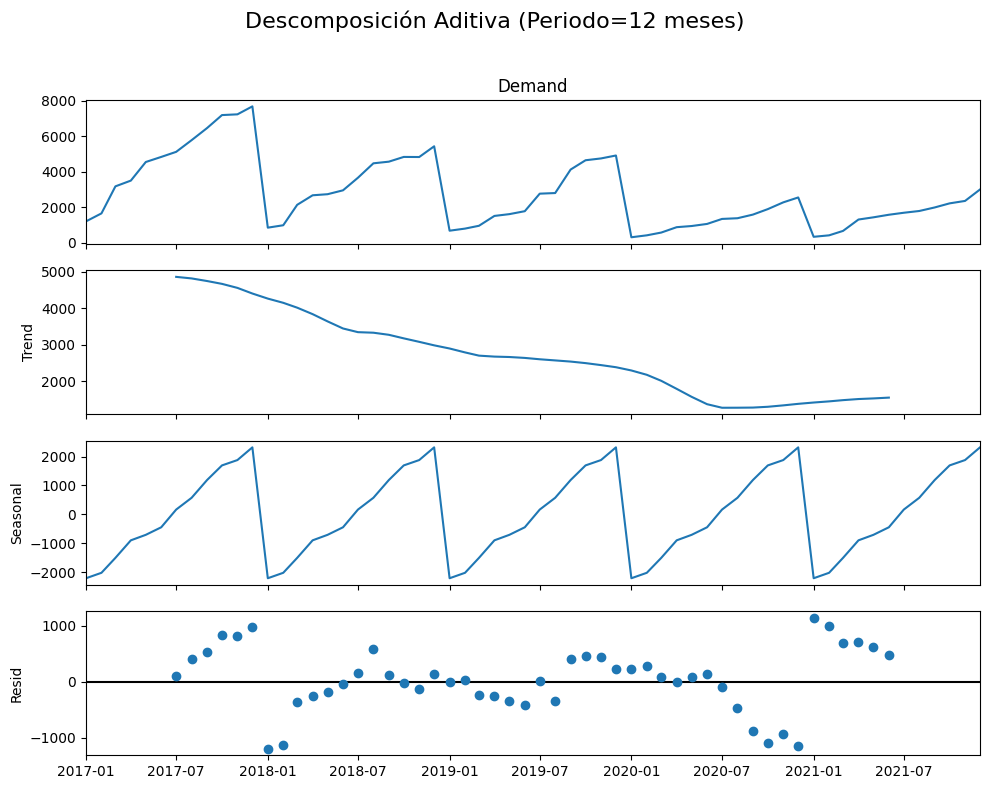

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

# A) seasonal_decompose requiere un índice datetime con frecuencia explícita
#    Asegurémonos de que el índice tenga frecuencia mensual:
train_indexed = train.copy()
train_indexed.index.freq = "MS"   # MS = Month Start

# B) Descomposición clásica aditiva:
decomp = seasonal_decompose(train_indexed["Demand"], model="additive", period=12)

# C) Graficamos los componentes
plt.rcParams.update({"figure.figsize": (10, 8)})
decomp.plot()
plt.suptitle("Descomposición Aditiva (Periodo=12 meses)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**Componente “Trend”:**

- Entre 2017 y principios de 2019 se ve una tendencia relativamente alta, luego a mediados de 2019 empieza a descender, y hacia mediados-finales de 2020 ronda valores bajos (~1.000). Hacia 2021 hay un ligero repunte de base (de ~1.200 a ~1.400).

- En general, la tendencia de largo plazo baja año a año hasta finales de 2020, y en 2021 comienza a subir de nuevo de forma suave.

**Componente “Seasonal” (periodo = 12 meses):**

- Cada año hay un patrón muy parecido: valores negativos al inicio (enero), luego sube en marzo-abril, alcanza máximo positivo hacia fin de año (noviembre/diciembre) y luego vuelve a caer en enero.

- La amplitud (distancia entre mínimo y máximo de la estacionalidad) casi se mantiene constante en cada ciclo anual; esto confirma que la estacionalidad es fuerte y bastante estable.

**Componente “Residual”:**

- Idealmente debería ser ruido blanco, pero se notan “picos” adicionales justo cuando la demanda “resetea” (por ejemplo, un residual muy negativo en enero de cada año).

- Esto sugiere que, aunque quitamos tendencia y estacionalidad, todavía queda un efecto puntual (por ejemplo, el salto abrupto de fin-2017 a inicios 2018) que no está capturado por el modelo aditivo en forma perfecta.


## **3.4 Rolling statistics: media y desviación móvil**

Para evaluar visualmente la estacionariedad (al menos en media y varianza), calculemos la media móvil y la desviación estándar móvil con ventana de 12 meses

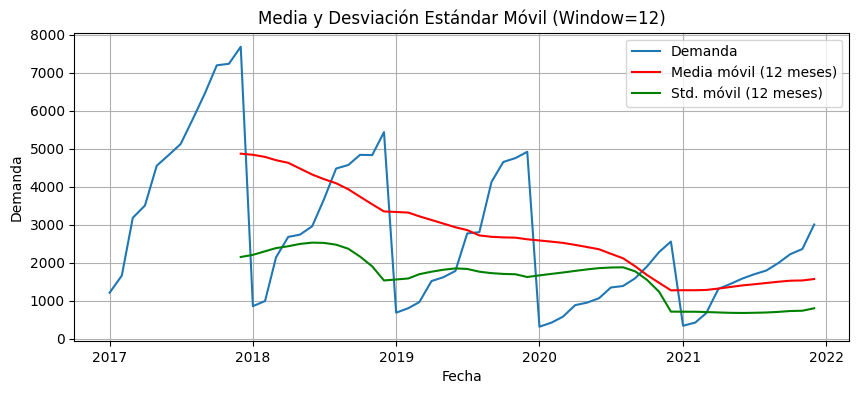

In [40]:
rol_mean = train["Demand"].rolling(window=12, center=False).mean()
rol_std  = train["Demand"].rolling(window=12, center=False).std()

plt.figure(figsize=(10, 4))
plt.plot(train.index, train["Demand"], label="Demanda")
plt.plot(rol_mean.index, rol_mean, color="red", label="Media móvil (12 meses)")
plt.plot(rol_std.index, rol_std, color="green", label="Std. móvil (12 meses)")
plt.title("Media y Desviación Estándar Móvil (Window=12)")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()


**Media móvil (12 meses, línea roja):**

- Muy marcada la caída de la media móvil de ~4.800 a inicios de 2018 hasta ~2.200–2.500 hacia mediados de 2020.

- A principios de 2021 se ve que la media se estabiliza en torno a ~1.200–1.600.

- **Conclusión:** existe un claro drift a la baja a lo largo de los años, y no es estacionario en media si no se corrige por ese descenso.

**Desviación estándar móvil (12 meses, línea verde):**

- Al principio (2017-2018), la variabilidad era alta (~2.100-2.500), luego decae lentamente hasta valores de ~1.800-1.900 hacia 2020.

- Hacia 2021, la varianza sigue siendo menor que en 2017; la serie se vuelve algo menos “volátil”.

- **Conclusión:** la varianza tampoco es estrictamente constante a lo largo del tiempo; hay una ligera heteroscedasticidad: en los primeros años los picos y valles se separan más que en 2020–2021.

## **3.5 Autocorrelación y autocorrelación parcial (ACF / PACF)**

Estos gráficos nos dicen qué rezagos (lags) son más relevantes. Para una serie mensual con estacionalidad anual típica, deberíamos ver un pico en el lag 12 (y múltiplos), así como una estructura en los primeros lags por la dependiencia a corto plazo.

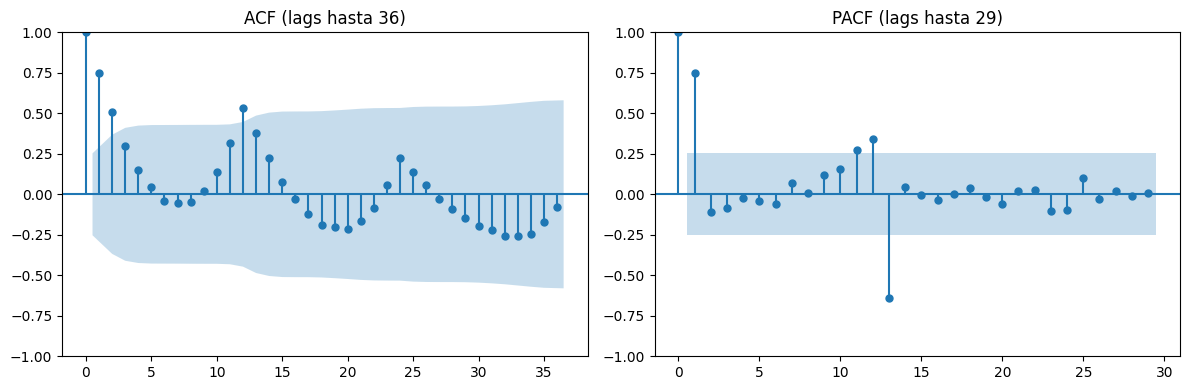

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(train["Demand"], lags=36, ax=plt.gca(), title="ACF (lags hasta 36)")

plt.subplot(1, 2, 2)
plot_pacf(train["Demand"], lags=29, ax=plt.gca(), title="PACF (lags hasta 29)") # Changed lags to 29

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- Lag 1: muy alta (casi 1.0). Tiene sentido: la demanda de un mes está muy correlacionada con la demanda del mes anterior.

- Lag 12: hay un pico positivo notable (≈ 0.53). Eso corrobora la estacionalidad anual (12 meses).

- También se ven pequeños picos en lags alrededor de 24, 36, aunque más débiles.

- A partir de lag 2 a lag 11 hay varias autocorrelaciones pequeñas positivas y negativas (la mayoría ya dentro de la banda de confianza), pero el pico más “fuerte” tras lag 1 es claramente el lag 12.

**PACF (Partial Autocorrelation Function):**

- Lag 1: muy alto (≈ 0.75).

- Lag 12: aparece un pico de ≈ 0.30.

- Queda relativamente “corto” más allá de lag 12, lo que sugiere que con AR(1) ( AR:autoregresivo) + SAR(1)(12) ( SAR: Seasonal Autoregressive)  ya se podría capturar buena parte de la dinámica.

**Implicación:**

- Hay dependencia a corto plazo (componente AR(1) ).

- Hay dependencia estacional a lag 12 (componente SAR(1)).

- No se ve un corte muy brusco en q (serie MA) para lags bajos, pero sí se ven autocorrelaciones moderadas negativas en algunos lags intermedios (p. ej. lag 2, lag 3). Ese detalle lo puliremos al elegir p, q o P, Q.



## **3.6 Prueba de estacionariedad (Dickey–Fuller)**

Para evaluar si la serie necesita diferencias (diferenciar) para volverse estacionaria, realizamos la prueba ADF. Si el p‐valor es menor a 0.05, podemos rechazar la hipótesis nula de no estacionariedad.

In [42]:
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(train["Demand"])
print("ADF Statistic: %.4f" % resultado_adf[0])
print("p-value: %.4f" % resultado_adf[1])
for key, value in resultado_adf[4].items():
    print(f"  Critical Value ({key}): {value:.4f}")


ADF Statistic: -4.1735
p-value: 0.0007
  Critical Value (1%): -3.5746
  Critical Value (5%): -2.9240
  Critical Value (10%): -2.6000


- **p-value = 0.0007 < 0.05:** se rechaza la hipótesis nula de “hay raíz unitaria (serie no estacionaria)”. Según esta prueba, la serie en nivel ya resulta estacionaria (al menos a un nivel de confianza del 5 %).

- **Pero atención:** el ADF estándar no toma en cuenta explícitamente una raíz estacional. En presencia de un patrón multiplicativo muy fuerte (que es el caso aquí, cada enero la serie hace un “reset” abrupto) la prueba puede “rebotar” muy rápidamente en los primeros lags, y por eso arrojar p < 0.05 aun cuando visualmente hay clara estacionalidad de periodo 12.

**Interpretación práctica:**

- No necesitamos —desde el punto de vista de ADF— hacer una diferencia no estacional (d = 0).

- Aun así, muy probablemente sí convenga “quitar” la componente estacional (es decir, aplicar diferenciación estacional D = 1, s = 12) o incorporar un término SARIMA que la modele.



## **3.7. Autocorrelación de la serie diferenciada (si la serie no es estacionaria)**

En caso de que el ADF devuelva un p‐value alto, crea la serie diferenciada de primer orden y repite ACF/PACF sobre esa serie:

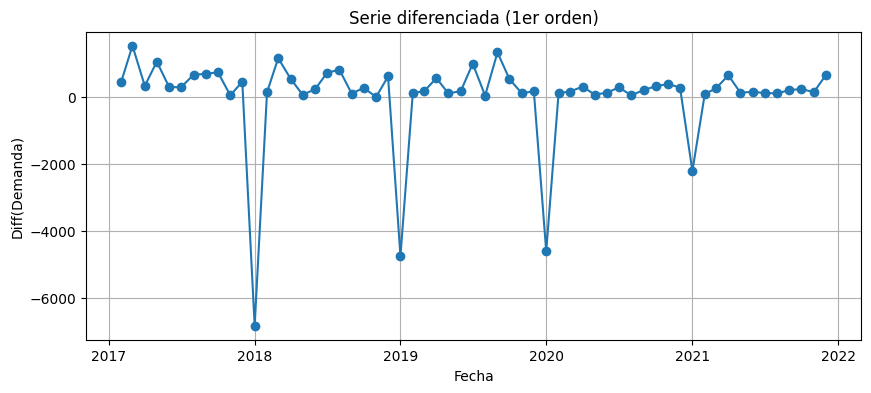

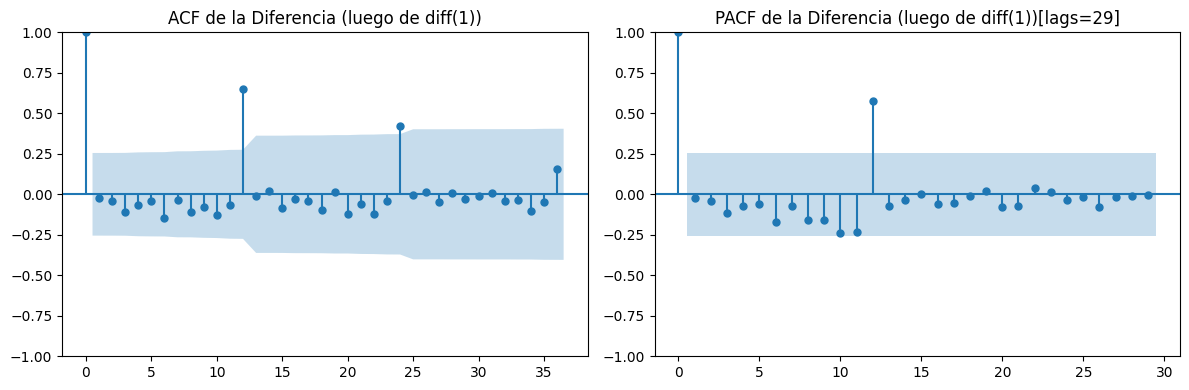

ADF Statistic (diff1): -1.4052
p-value (diff1): 0.5798
  Critical Value (1%): -3.5778
  Critical Value (5%): -2.9253
  Critical Value (10%): -2.6008


In [43]:
# Si la prueba ADF indicara que no es estacionaria:
diff1 = train["Demand"].diff().dropna()

plt.figure(figsize=(10, 4))
plt.plot(diff1.index, diff1, marker="o", linestyle="-")
plt.title("Serie diferenciada (1er orden)")
plt.xlabel("Fecha")
plt.ylabel("Diff(Demanda)")
plt.grid(True)
plt.show()

# ACF/PACF de la serie diferenciada
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(diff1, lags=36, ax=plt.gca(), title="ACF de la Diferencia (luego de diff(1))")

plt.subplot(1, 2, 2)
plot_pacf(diff1, lags=29, ax=plt.gca(), title="PACF de la Diferencia (luego de diff(1))[lags=29]")

plt.tight_layout()
plt.show()

# Volvemos a hacer ADF sobre la serie diferenciada
res_adf_diff1 = adfuller(diff1)
print("ADF Statistic (diff1): %.4f" % res_adf_diff1[0])
print("p-value (diff1): %.4f" % res_adf_diff1[1])
for key, val in res_adf_diff1[4].items():
    print(f"  Critical Value ({key}): {val:.4f}")


**Diferenciación de primer orden (d = 1) y ACF/PACF sobre la serie diferenciada**
- Al graficar la serie “one‐diff” (cada mes – mes anterior) se ven picos muy negativos en los puntos de “corte de año” (por ejemplo, de 2017-12 a 2018-01, 2018-12 a 2019-01, etc.). Es decir, al restar mes a mes, el reinicio anual crea saltos muy abruptos (~–6.500, –5.000, –2.100, –2.400, –2.000).

En la **ACF de la serie diferenciada:**
  - Hay un pico en lag 0 (siempre es 1).
  
  -El siguiente pico fuerte es en lag 12 (≈ 0.65), lo cual refuerza que la dependencia estacional sigue intacta.

- Para lags entre 1 y 11 hay varios autocorrelogramas negativos muy leves y algunos positivos, pero la señal dominante sigue en lag 12.

En la **PACF de la serie diferenciada:**

- Lag 1 es algo negativo (≈ –0.10), luego lag 12 vuelve a salir muy pronunciado (≈ 0.55).

- A partir de lag 13 en adelante no hay valores fuera de las bandas de confianza.



**ADF sobre la serie diferenciada:**

- p-value ≈ 0.58 >> 0.05 → NO podemos rechazar la hipótesis de raíz unitaria. Es decir, la serie diferenciada de grado 1 (d = 1) **sigue sin ser estacionaria.**

- Ese resultado “aparentemente contradictorio” (la original pasa ADF y la diferenciada de grado 1 no) ocurre porque la distribución de la serie después de restar mes a mes se ve muy influida por esos saltos anuales.

- **Implicación:** no convendría usar d = 1 (diferencia simple). La prueba ADF nos dice que, de hecho, la serie en nivel ya es estacionaria (por lo menos en el sentido de esa prueba univariante).



## **3.8 Gráfica de tendencias de largo plazo**

Para observar la tendencia a largo plazo, puedes suavizar la serie con una ventana mayor (p. ej. 24 o 36 meses). Esto a veces aclara si hay un cambio de régimen (picos muy fuertes que cambian la pendiente de la tendencia).

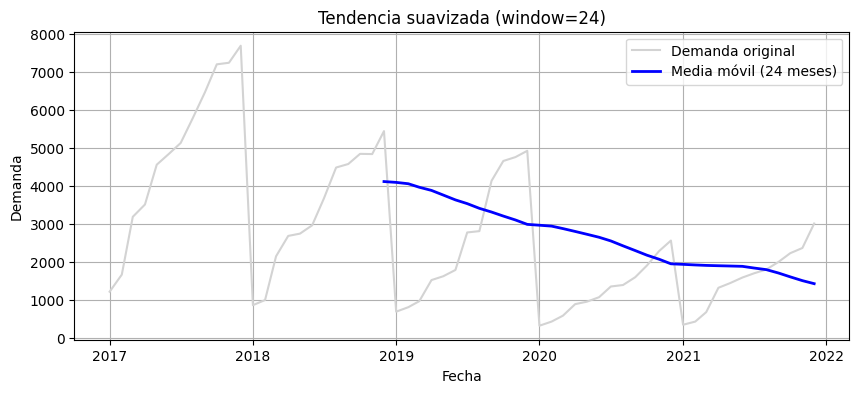

In [44]:
# Media móvil 24 meses
rol_24 = train["Demand"].rolling(window=24, center=False).mean()

plt.figure(figsize=(10, 4))
plt.plot(train.index, train["Demand"], color="lightgray", label="Demanda original")
plt.plot(rol_24.index, rol_24, color="blue", linewidth=2, label="Media móvil (24 meses)")
plt.title("Tendencia suavizada (window=24)")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()


- La media móvil de 24 meses muestra una pendiente descendente muy sostenida desde finales de 2017 hasta mediados de 2020.

- Hacia finales de 2020/principios de 2021 la media movil cae prácticamente al mínimo (~ 1.200). Luego, a lo largo de 2021, se observa un ligero repunte de la base (~1.200 → 1.400).

- **Interpretación:** la demanda anual máxima y el promedio anual han bajado mucho en 2019 y 2020 con respecto a 2017-2018. A partir de 2021 parece haber un inicio de recuperación, pero de escala menor a los niveles de 2017

## **3.9 Conclusiones generales del EDA**


- **Fuerte estacionalidad anual**
Cada año se repite un patrón muy marcado: en diciembre siempre se alcanzan los picos más altos de demanda, y justo en enero hay una caída abrupta que “reinicia” el ciclo. Esto se ve claramente al descomponer la serie y también en los gráficos de ACF/PACF, donde aparece un pico muy fuerte en el retardo 12 (es decir, un año atrás).

- **Tendencia a largo plazo**
La demanda promedio baja de 2017 a 2020. A partir de 2021 comienza a subir un poco, pero el nivel general sigue siendo más bajo que en 2018 o 2019. Si miramos la media móvil, notamos que la serie no se mantiene en un nivel constante: hasta principios de 2021 hay una caída lenta (drift) y luego un ligero repunte.

- **¿Es estacionaria en nivel?**
El test ADF sobre la serie original dio un p = 0.0007, lo que a primera vista indica que la serie es estacionaria. Sin embargo, visualmente notamos esa tendencia y la estacionalidad fuerte, y probablemente el test se “engañó” un poco por la repetición anual de los picos y valles. Cuando aplicamos una diferencia simple (restar mes a mes) y volvimos a hacer ADF, el p subió a alrededor de 0.58, es decir, la serie diferenciada ya no era estacionaria. Esto significa que no tiene sentido quitar la tendencia con diferencia normal, pues los cambios drásticos de año a año vuelven inestable la serie.

- **Componentes AR y SAR**
En el PACF se ve que después de lag 1 ya no hay mucha información, y de nuevo aparece un pico fuerte en lag 12. En el ACF, los retardos 1 y 12 son los que más importan. Eso sugiere que, para un modelo SARIMA, podría bastar con un término AR(1) y un SAR(1): o sea, p=1 y P=1. No se ve un MA(1) muy claro en los gráficos, así que podríamos empezar con q=0 y Q=0, y luego probar si añadir MA ayuda.

- **Decisión preliminar sobre differencing**
No conviene aplicar diferencia no estacional (d=1): tras diferenciar mes a mes, la serie queda demasiado inestable y el ADF empeoró. Lo más sensato es no usar d=1, sino modelar la tendencia con un término de “drift” o bien incluir un parámetro lineal en el intercepto de SARIMAX. La estacionalidad la podemos manejar directamente con D=1 (diferencia estacional) o incorporar un componente SAR(1). Otra opción flexible es usar Prophet, que separa explícitamente “tendencia” y “estacionalidad”.

- **Distribución sesgada**
Hay pocos meses con picos muy altos (> 7 000) y muchos meses en rangos más bajos (1 200–4 500). Para evitar que esos picos dominen el modelo, conviene aplicar una transformación logarítmica a la demanda (por ejemplo, usar y′ = log(Demanda) en lugar de la demanda cruda). Así los residuos tienden a tener varianza más constante y, al generar pronósticos, luego se retransforma con exp() para volver a la escala original.

---


# **4. EDA -  Train Data (transformacion escala)**

Vamos a repetir algunos de los pasos clave del EDA, pero esta vez aplicando

## **4.1 Comparativa Demanda en Escala Original vs. Escala Logarítmica**

Para estabilizar la varianza y facilitar el análisis de series temporales, definimos la nueva variable **log_Demand** de la siguiente forma:

$$
\log\_Demand_{t} \;=\; \log\bigl(\mathrm{Demand}_{t}\bigr)
$$

**Dónde:**
- $\mathrm{Demand}_{t}$ es el valor original de la demanda en el periodo $t$.
- $\log(\cdot)$ corresponde al logaritmo natural (base $e$).

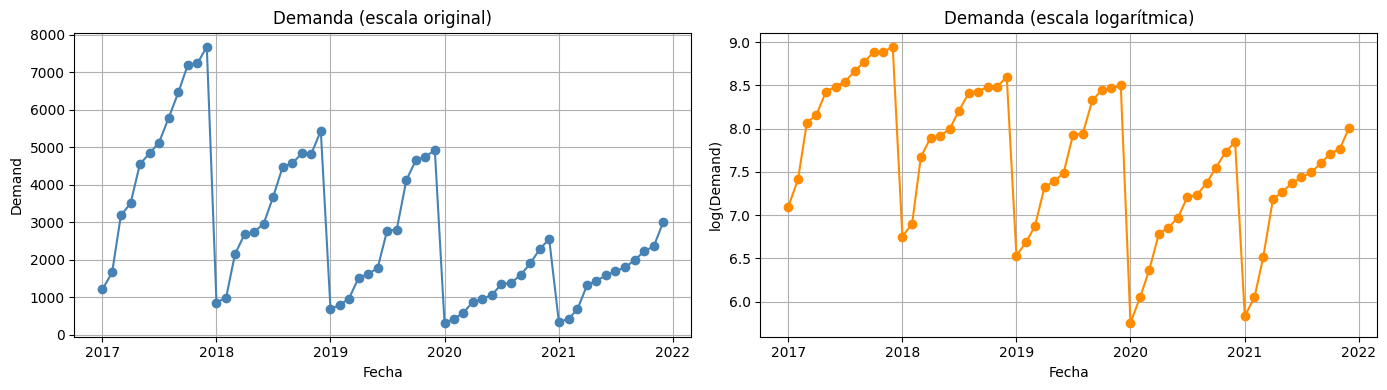

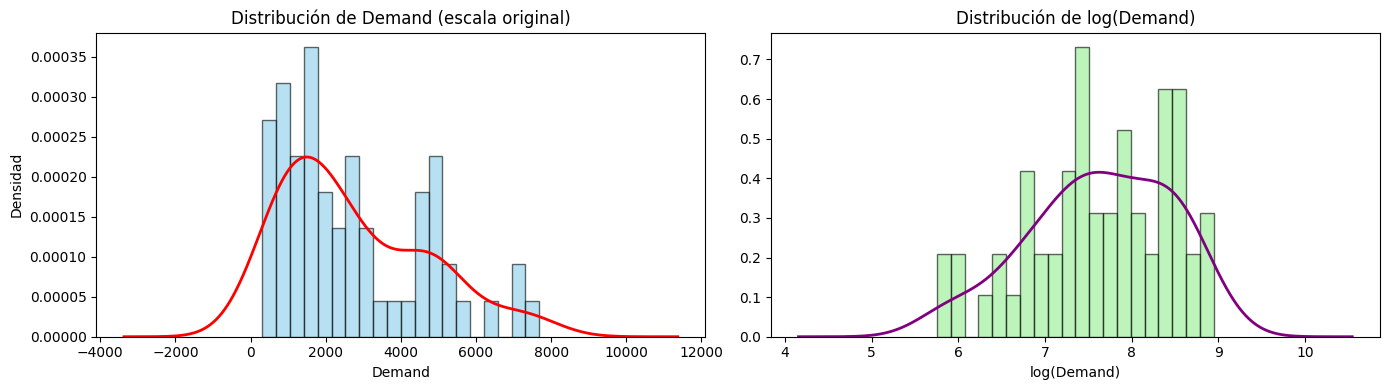

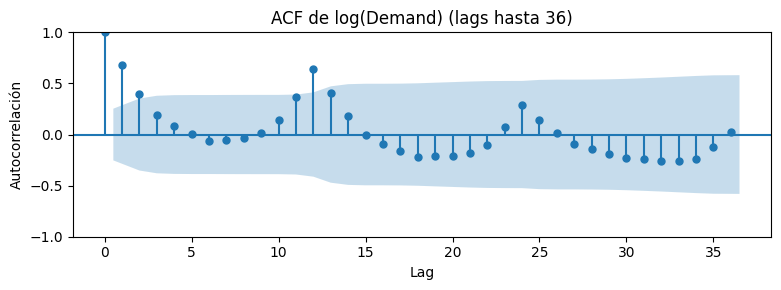

===== Prueba ADF sobre log(Demand) =====
ADF Statistic: -2.3828
p-value:      0.1466
  Critical Value (1%): -3.5746
  Critical Value (5%): -2.9240
  Critical Value (10%): -2.6000


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

train["log_Demand"] = np.log(train["Demand"])

# 1) Serie original vs. serie en log: dos paneles en una fila
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharex=False, sharey=False)

# a) Serie en escala original
axes[0].plot(train.index, train["Demand"], marker="o", linestyle="-", color="steelblue")
axes[0].set_title("Demanda (escala original)")
axes[0].set_xlabel("Fecha")
axes[0].set_ylabel("Demand")
axes[0].grid(True)

# b) Serie en escala logarítmica
axes[1].plot(train.index, train["log_Demand"], marker="o", linestyle="-", color="darkorange")
axes[1].set_title("Demanda (escala logarítmica)")
axes[1].set_xlabel("Fecha")
axes[1].set_ylabel("log(Demand)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(ncols=2, figsize=(14, 4))

# ----------------------------------------------------------
# a) Histograma + KDE en escala original
# ----------------------------------------------------------
axes[0].hist(
    train["Demand"],
    bins=20,                # un número de bins algo más fino ayuda a ver mejor la forma
    density=True,
    alpha=0.6,
    edgecolor="black",
    color="skyblue",
)
train["Demand"].plot(
    kind="kde",
    color="red",
    ax=axes[0],
    linewidth=2,
)
axes[0].set_title("Distribución de Demand (escala original)", fontsize=12)
axes[0].set_xlabel("Demand", fontsize=10)
axes[0].set_ylabel("Densidad", fontsize=10)
axes[0].grid(False)

# ----------------------------------------------------------
# b) Histograma + KDE en escala logarítmica
# ----------------------------------------------------------
axes[1].hist(
    train["log_Demand"],
    bins=20,
    density=True,
    alpha=0.6,
    edgecolor="black",
    color="lightgreen",
)
train["log_Demand"].plot(
    kind="kde",
    color="purple",
    ax=axes[1],
    linewidth=2,
)
axes[1].set_title("Distribución de log(Demand)", fontsize=12)
axes[1].set_xlabel("log(Demand)", fontsize=10)
axes[1].set_ylabel("")
axes[1].grid(False)

plt.tight_layout()
plt.show()


# 3) ACF de la serie en escala log (en un solo panel, por claridad)
plt.figure(figsize=(8, 3))
plot_acf(train["log_Demand"], lags=36, ax=plt.gca())
plt.title("ACF de log(Demand) (lags hasta 36)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelación")
plt.tight_layout()
plt.show()


# 4) Prueba ADF sobre la serie en escala log
resultado_adf_log = adfuller(train["log_Demand"])
print("===== Prueba ADF sobre log(Demand) =====")
print(f"ADF Statistic: {resultado_adf_log[0]:.4f}")
print(f"p-value:      {resultado_adf_log[1]:.4f}")
for clave, valor in resultado_adf_log[4].items():
    print(f"  Critical Value ({clave}): {valor:.4f}")


** Comparación de tendencia: nivel vs. log**

- En nivel (azul) la demanda salta de unos cientos a casi 7 700, claramente desigual.

- En log (naranja) esos mismos saltos se “comprimen” entre aproximadamente 5.7 (enero 2017) y 8.95 (diciembre 2017), luego entre 6.7 y 8.8 en 2018, etc.

- Como consecuencia, en log la amplitud de la curva es mucho más homogénea a lo largo de los cinco años: los picos anuales no se ven tan extremos, y las oscilaciones mensuales tienen una escala relativamente constante.

**Implicación:** la transformación logarítmica sí estabiliza en buena medida la variabilidad de la serie (la “varianza” ahora parece más uniforme).

**Distribuciones: histograma y KDE en nivel vs. log**

- En nivel, el histograma de Demand original está fuertemente sesgado a la derecha: la mayoría de los valores ―entre ~300 y ~4 500― y unos pocos puntos muy altos (la cola larga hasta 7 700), por lo que la KDE (línea roja) queda muy achatada hacia la derecha.

- En log, la distribución de log(Demand) es mucho más cercana a una campana, con una forma relativamente simétrica alrededor de ~7.8. La cola extrema se ha “acomodado” y vemos claramente un pico central más pronunciado.

**Implicación:** modelar en escala log hace que la variable objetivo se aproxime más a una distribución normal (o al menos mucho menos sesgada), lo cual suele ser deseable si mañana usamos un modelo lineal (como SARIMA) o incluso un modelo de Machine Learning que suponga “errores” con varianza estable.

**ACF de la serie logarítmica**

- En lag 1, la autocorrelación sigue siendo muy alta (≈0.70).

- En lag 12, reaparece un pico claro (≈0.55), lo que confirma que la estacionalidad anual persiste incluso en escala log.

- Del mismo modo que en nivel, vemos autocorrelaciones ligeramente negativas en los lags intermedios (cercanos a 2, 3, 4, etc.), pero el patrón dominante sigue siendo:

  1. Dependencia fuerte mes a mes (AR(1)),

  2. Estacionalidad fuerte a 12 meses (SAR(12)).

**Implicación:** la transformación logarítmica no “rompe” la estacionalidad ni la dependencia a corto plazo; simplemente atenúa la varianza. Por tanto, seguiremos necesitando un modelo que capte AR(1) y SAR(12).

**Prueba ADF sobre la serie logarítmica**

- El p-value ≈ 0.1466 es mayor que 0.05.

- Por tanto, no rechazamos la hipótesis nula de “serie no estacionaria” cuando trabajamos con log(Demand) en nivel.

- Esto significa que, a diferencia de la serie original (donde ADF devolvió p < 0.05), la serie en escala log sí necesita alguna diferencia para volverse estacionaria.

## **4.2 prueba ADF sobre diferencia estacional de log(Demand)**

En esta sección aplicamos una diferencia estacional (lag = 12) sobre la serie de log(Demand) con el objetivo de eliminar el patrón anual y “aplanar” la tendencia

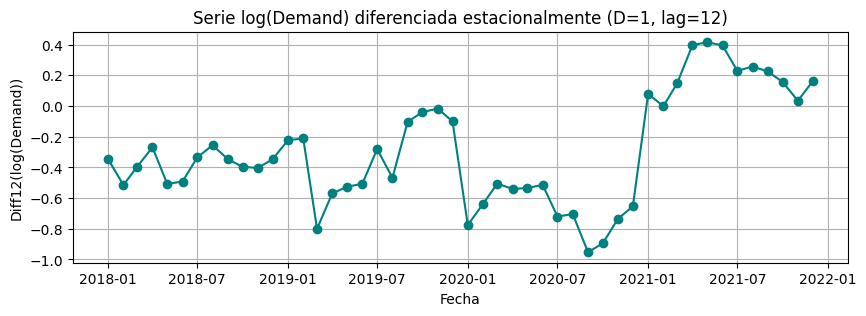

===== Prueba ADF sobre Diff12(log(Demand)) =====
ADF Statistic: -1.8847
p-value:      0.3393
  Critical Value (1%): -3.5778
  Critical Value (5%): -2.9253
  Critical Value (10%): -2.6008


In [46]:
from statsmodels.tsa.stattools import adfuller

# 1) Diferencia estacional en log (lag=12)
seasonal_diff_log = train["log_Demand"].diff(12).dropna()

# 2) Graficamos la serie resultante para ver visualmente si ya está “aplanada”
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(seasonal_diff_log.index, seasonal_diff_log, marker="o", linestyle="-", color="teal")
plt.title("Serie log(Demand) diferenciada estacionalmente (D=1, lag=12)")
plt.xlabel("Fecha")
plt.ylabel("Diff12(log(Demand))")
plt.grid(True)
plt.show()

# 3) Prueba ADF sobre la serie diferenciada estacionalmente
resultado_adf_seas = adfuller(seasonal_diff_log)
print("===== Prueba ADF sobre Diff12(log(Demand)) =====")
print(f"ADF Statistic: {resultado_adf_seas[0]:.4f}")
print(f"p-value:      {resultado_adf_seas[1]:.4f}")
for clave, valor in resultado_adf_seas[4].items():
    print(f"  Critical Value ({clave}): {valor:.4f}")


**Gráfica de la serie log(Demand) diferenciada estacionalmente (D=1, lag=12)**

- Tras quitar el componente estacional (restar cada valor de log(Demand) con el mismo mes del año anterior), la serie resultante ya no muestra los saltos tan bruscos de enero de cada año.

- Sin embargo, la variabilidad (la dispersión alrededor de cero) aún no es completamente “ruido blanco”: vemos que existen zonas (sobre todo a partir de inicios de 2021) donde hay un desplazamiento positivo sostenido, y antes de eso (2018–2020) un desplazamiento negativo o cercano a cero. Esto sugiere que todavía queda una tendencia (no‐estacional) en la serie.

**Prueba ADF sobre Diff12(log(Demand))**
- El p-value = 0.3393 es mayor que 0.05, por lo que no podemos rechazar la hipótesis nula de “serie con raíz unitaria” (no‐estacionaria) en este nivel de confianza.

- Esto confirma que, aunque quitamos la estacionalidad anual, la serie en escala log aún conserva una tendencia o “drift” a lo largo del tiempo. En otras palabras, la serie Diff12(log(Demand)) sigue sin ser estacionaria.




## **4.3 Verificar la estacionariedad tras la doble diferencia en log**

Para confirmar que estamos “en el punto” de estacionariedad, vamos a crear la serie con ((log → diferencia estacional) → diferencia no estacional) y volver a aplicar ADF. Deberíamos ver un p-value < 0.05

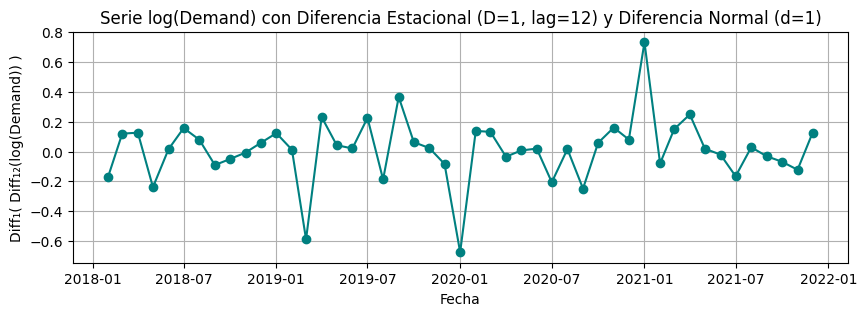

===== Prueba ADF sobre Diff₁(Diff₁₂(log(Demand))) =====
ADF Statistic: -7.4838
p-value:      0.0000
  Critical Value (1%): -3.5813
  Critical Value (5%): -2.9268
  Critical Value (10%): -2.6015


In [47]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# 1) Crear la serie diferenciada estacionalmente (D=1): diff12_log
diff12_log = train["log_Demand"].diff(12)

# 2) A esa serie le aplicamos diferencia no-estacional (d=1): diff12_d1_log
diff12_d1_log = diff12_log.diff(1).dropna()

# 3) Graficamos diff12_d1_log para ver su aspecto
plt.figure(figsize=(10, 3))
plt.plot(diff12_d1_log.index, diff12_d1_log, marker="o", linestyle="-", color="teal")
plt.title("Serie log(Demand) con Diferencia Estacional (D=1, lag=12) y Diferencia Normal (d=1)")
plt.xlabel("Fecha")
plt.ylabel("Diff₁( Diff₁₂(log(Demand)) )")
plt.grid(True)
plt.show()

# 4) Prueba ADF sobre la serie doblemente diferenciada
result_adf_double = adfuller(diff12_d1_log)
print("===== Prueba ADF sobre Diff₁(Diff₁₂(log(Demand))) =====")
print(f"ADF Statistic: {result_adf_double[0]:.4f}")
print(f"p-value:      {result_adf_double[1]:.4f}")
for key, val in result_adf_double[4].items():
    print(f"  Critical Value ({key}): {val:.4f}")


**Salida de ADF para $\Delta_{1}(\Delta_{12}(\log(\mathrm{Demand})))$**




- El p-value es prácticamente cero, por lo que **rechazamos con mucho margen la hipótesis nula de raíz unitaria**.
- Esto confirma que la serie
  $$
    Z_{t} \;=\; \Delta_{1}\bigl(\Delta_{12}(\log(\mathrm{Demand}))\bigr)
  $$
  es estacionaria. En otras palabras, con \(d = 1\) (diferencia no estacional) y \(D = 1,\,s = 12\) (diferencia estacional), ya hemos logrado “aplanar” la serie logarítmica.


#  **5. ML: SARIMA sobre log(Demand)**

la prueba ADF anterior confirma estacionariedad (p-value < 0.05), entonces podemos dar el siguiente paso:

- Entregar a statsmodels (o pmdarima.auto_arima) la configuración (p,d,q)=(1,1,0) y (P,D,Q,s)=(1,1,0,12)
- Evaluar métricas (RMSE, MAPE, R²) comparando con el bloque de validación (enero–abril 2022) si queremos hacer validación interna, o directamente aceptar la predicción final (para 2022-05 a 2022-07) si ya definimos ese procedimiento.

##**5.1 SARIMA(1,1,0)x(1,1,0,12)**

In [48]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

log_train = train["log_Demand"]

#  Ajustamos SARIMA(1,1,0)x(1,1,0,12)
model = SARIMAX(
    log_train,
    order=(1, 1, 0),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)
print(res.summary())

#  Pronóstico en el periodo de validación interior: 2022-01 a 2022-04
#    Primero creamos un índice de fechas para esos 4 meses (freq='MS' → mes inicio)
future_valid_idx = pd.date_range(start="2022-01-01", end="2022-04-01", freq="MS")

#    Generamos predicción para esos pasos
pred_valid_log = res.get_prediction(start=future_valid_idx[0], end=future_valid_idx[-1])
pred_valid_log_mean = pred_valid_log.predicted_mean  # en log

#    Pasamos a escala original:
pred_valid_orig = np.exp(pred_valid_log_mean)

#  Comparamos contra los valores reales (enero–abril 2022) para calcular métricas
y_true_valid = df.loc["2022-01-01":"2022-04-01", "Demand"]  # original
y_pred_valid = pred_valid_orig

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse_valid = np.sqrt(mean_squared_error(y_true_valid.values, y_pred_valid.values))
mape_valid = np.mean(np.abs((y_true_valid.values - y_pred_valid.values) / y_true_valid.values)) * 100
r2_valid = r2_score(y_true_valid.values, y_pred_valid.values)

print(f"Validación (2022-01 a 2022-04) → RMSE: {rmse_valid:.2f}, MAPE: {mape_valid:.2f}%, R²: {r2_valid:.4f}")


                                     SARIMAX Results                                      
Dep. Variable:                         log_Demand   No. Observations:                   60
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   5.762
Date:                            Tue, 03 Jun 2025   AIC                             -5.524
Time:                                    04:30:54   BIC                             -0.945
Sample:                                01-01-2017   HQIC                            -3.962
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1713      0.272     -0.629      0.529      -0.705       0.362
ar.S.L12      -0.6198      0.155   

- ar.L1 (AR no estacional de orden 1): coef ≈ −0.171, p‐value ≈ 0.529.

- Esto significa que, condicional al resto de términos, el AR(1) “normal” no es estadísticamente significativo en la escala log-diferenciada.

- En muchos casos podríamos plantearnos simplificar el modelo quitando el término AR(1), lo que daría un **SARIMA(0,1,0)×(1,1,0)[12].**

**RMSE ≈ 150** (unidad de demanda). Significa que, en promedio, nuestros pronósticos difieren del valor real en alrededor de 150 toneladas (o unidades, según la métrica).

**MAPE ≈ 16%:** en promedio el error porcentual es del 16 %. Para algunas aplicaciones industriales, podría considerarse aceptable; para otras, quizá se desee algo menor (10 % o menos).

**R² ≈ 0.78:** indica que el modelo explica el 78 % de la variabilidad de los datos en ese periodo de validación.

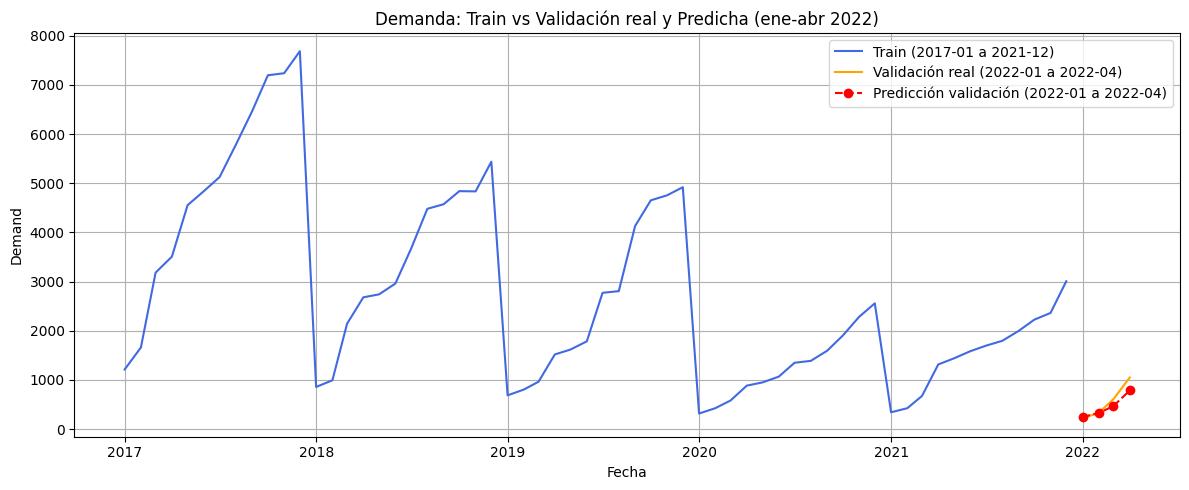

In [49]:
#------------------------------------------------
# Graficar train, valid real y valid predicha
# -------------------------------------------------------
plt.figure(figsize=(12, 5))

# (a) Serie de entrenamiento (hasta 2021-12)
plt.plot(train.index, train["Demand"], color="royalblue", label="Train (2017-01 a 2021-12)")

# (b) Serie de validación real (2022-01 a 2022-04)
plt.plot(valid.index, valid["Demand"], color="orange", label="Validación real (2022-01 a 2022-04)")

# (c) Serie de validación predicha (2022-01 a 2022-04)
plt.plot(pred_valid_orig.index, pred_valid_orig.values,
         color="red", linestyle="--", marker="o", label="Predicción validación (2022-01 a 2022-04)")

plt.title("Demanda: Train vs Validación real y Predicha (ene-abr 2022)")
plt.xlabel("Fecha")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **5.2 SARIMA(1,1,0)x(1,1,0)[12]**

Ajuste de SARIMA(0,1,1)×(1,1,0)[12] sobre la serie en escala log

                                      SARIMAX Results                                      
Dep. Variable:                          log_Demand   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                   6.160
Date:                             Tue, 03 Jun 2025   AIC                             -6.321
Time:                                     04:30:54   BIC                             -1.655
Sample:                                 01-01-2017   HQIC                            -4.710
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1107      0.246     -0.450      0.653      -0.593       0.372
ar.S.L12      -0.5987      

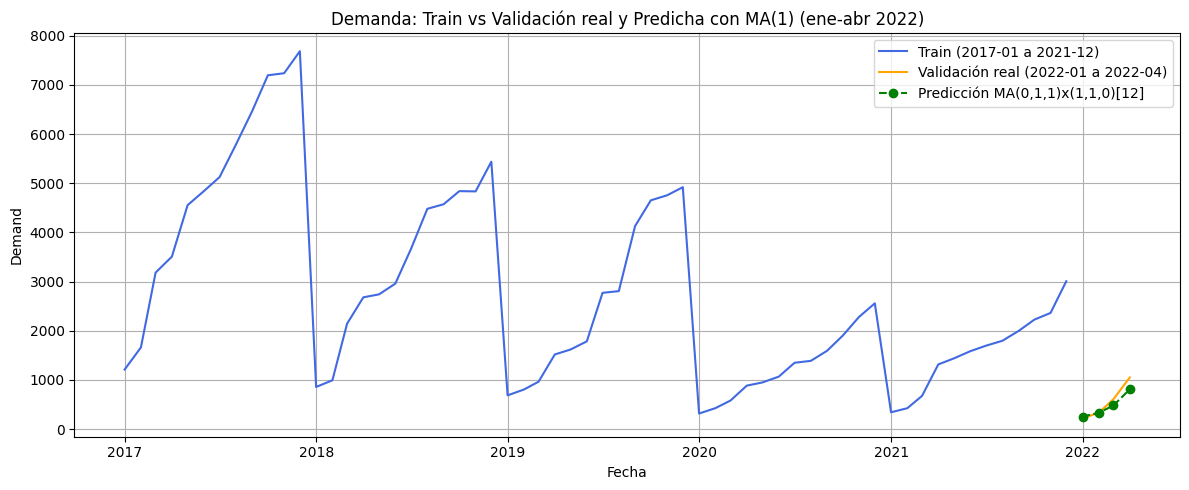

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score


# -------------------------------------------------------
#  Ajustar SARIMA(0,1,1)x(1,1,0)[12] sobre log(Demand) de train
# -------------------------------------------------------
log_train = train["log_Demand"]

model_ma = SARIMAX(
    log_train,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_ma = model_ma.fit(disp=False)
print(res_ma.summary())

# -------------------------------------------------------
#  Generar predicciones para validación (enero-abril 2022)
# -------------------------------------------------------
future_valid_idx = pd.date_range(start="2022-01-01", end="2022-04-01", freq="MS")
pred_valid_log_ma = res_ma.get_prediction(start=future_valid_idx[0], end=future_valid_idx[-1])
pred_valid_log_mean_ma = pred_valid_log_ma.predicted_mean
pred_valid_orig_ma = np.exp(pred_valid_log_mean_ma)

# -------------------------------------------------------
#  Calcular métricas de validación
# -------------------------------------------------------
y_true_valid = valid["Demand"].values
y_pred_valid_ma = pred_valid_orig_ma.values

rmse_ma = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid_ma))
mape_ma = np.mean(np.abs((y_true_valid - y_pred_valid_ma) / y_true_valid)) * 100
r2_ma  = r2_score(y_true_valid, y_pred_valid_ma)

print(f"SARIMA(0,1,1)x(1,1,0)[12] → RMSE: {rmse_ma:.2f}, MAPE: {mape_ma:.2f}%, R²: {r2_ma:.4f}")

# -------------------------------------------------------
#  Graficar train, valid real y valid predicha (MA)
# -------------------------------------------------------
plt.figure(figsize=(12, 5))

# (a) Serie de entrenamiento (hasta 2021-12)
plt.plot(train.index, train["Demand"], color="royalblue", label="Train (2017-01 a 2021-12)")

# (b) Serie de validación real (2022-01 a 2022-04)
plt.plot(valid.index, valid["Demand"], color="orange", label="Validación real (2022-01 a 2022-04)")

# (c) Serie de validación predicha (2022-01 a 2022-04) con MA
plt.plot(pred_valid_orig_ma.index, pred_valid_orig_ma.values,
         color="green", linestyle="--", marker="o", label="Predicción MA(0,1,1)x(1,1,0)[12]")

plt.title("Demanda: Train vs Validación real y Predicha con MA(1) (ene-abr 2022)")
plt.xlabel("Fecha")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Comparación entre especificaciones**

- El modelo SARIMA(1,1,0)×(1,1,0)[12] había dado un RMSE de ~150 y un MAPE ~16 %.

- Al probar SARIMA(0,1,1)×(1,1,0)[12], el RMSE baja a ~138 y el MAPE a ~15.3 %, con un R² superior.

- Incluso cuando el coeficiente MA(1) no es significativo, el AIC total del modelo (≈ −6.321) mejora frente al AIC anterior (≈ −5.524) y las métricas de validación también mejoran.

- Esto suele suceder: a veces un parámetro “poco significativo” desde el punto de vista estadístico aporta un pequeño ajuste que mejora la predictibilidad, aunque su p‐value sea alto.

**Importancia de la parte estacional**

- En ambos casos, el coeficiente ar.S.L12 ≈ −0.60 es el término que de verdad captura la estacionalidad y está fuertemente fuera de cero (p<0.001).

- La toma de decisión clave es que D = 1 (diferencia estacional) y P = 1 (SAR(12)) son imprescindibles, independientemente de si incluimos o no un AR(1) o un MA(1) en la parte no estacional.

**Residuos y normalidad**

- Con la inclusión de MA(1), la heterocedasticidad casi desaparece (p = 0.14) y la autocorrelación de residuos ya no es significativa (Ljung-Box p = 0.85).

- La prueba Jarque-Bera (p ≈ 0.01) indica que los residuos siguen sin ser perfectamente normales, pero la mejora con MA(1) usualmente se nota en la “forma” de la campana de los residuos (disminuye levemente la curtosis excesiva).

**Conclusion**

Dado que SARIMA(0,1,1)×(1,1,0)[12] mejora tanto AIC como métricas de validación, lo más razonable sería adoptarlo como modelo definitivo en escala log.


---

Creamos un pipeline completo con le meejor modelo en donde reentrenamos tanto el conjunto de validacion como el test y los comparamos. Tambien se crea el archvio cvs con todo el conjunto de datos y la grafica solicitada

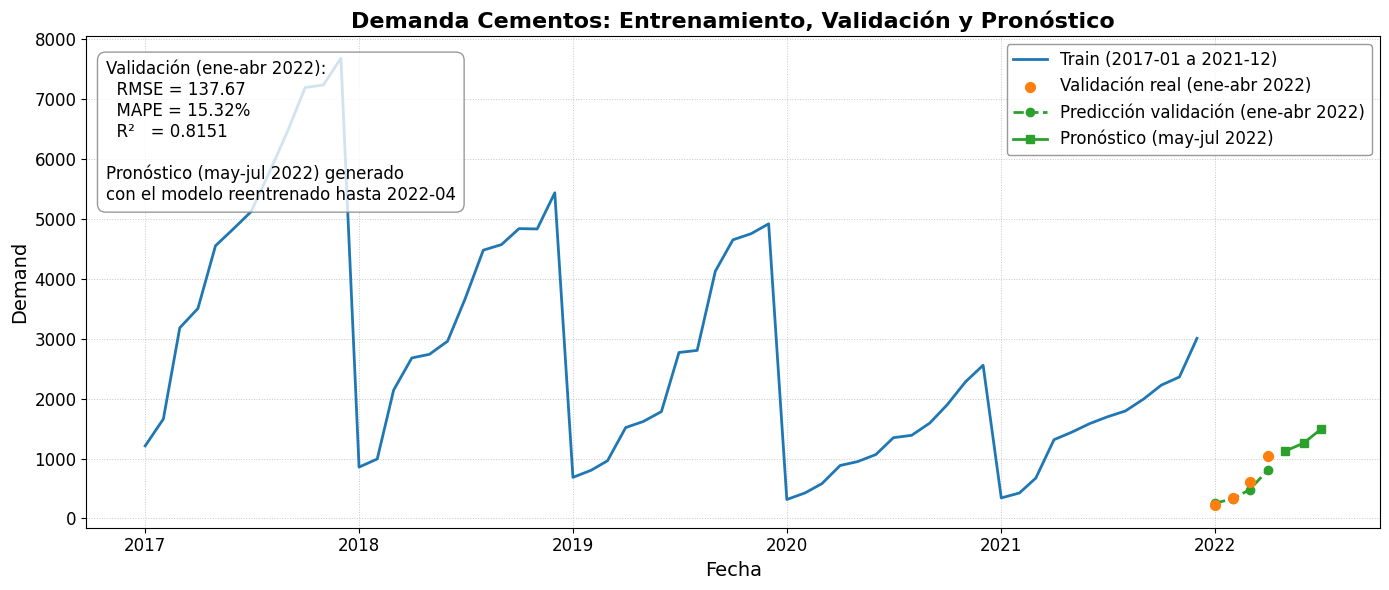

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------------------------------
#  Definimos train, valid y full
# -------------------------------------------------------
train = df.loc[: "2021-12-01"].copy()
valid = df.loc["2022-01-01": "2022-04-01"].copy()
full  = df.loc[: "2022-04-01"].copy()

# -------------------------------------------------------
#  Creamos la columna logarítmica en train y full
# -------------------------------------------------------
train["log_Demand"] = np.log(train["Demand"])
full["log_Demand"]  = np.log(full["Demand"])

# ---------------------------------------------------
#  MODELO para MÉTRICAS (solo ENTRENAMIENTO hasta 2021-12)
# ---------------------------------------------------
log_train = train["log_Demand"]
model_train = SARIMAX(
    log_train,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_train = model_train.fit(disp=False)


# Predicciones enero-abril 2022 (validación)
fidx_valid = pd.date_range("2022-01-01", "2022-04-01", freq="MS")
pred_val_log = res_train.get_prediction(start=fidx_valid[0],
                                        end=fidx_valid[-1]).predicted_mean
pred_val = np.exp(pred_val_log)

# Métricas (válidas porque el modelo NO vio esos datos)
y_true = valid["Demand"].values
y_pred = pred_val.values
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
mape_val = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_val   = r2_score(y_true, y_pred)

# ---------------------------------------------------
# MODELO FINAL para FORECAST (entrenado hasta 2022-04)
# ---------------------------------------------------
log_full = full["log_Demand"]
model_full = SARIMAX(
    log_full,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_full = model_full.fit(disp=False)

# Pronóstico mayo-julio 2022
fidx_fore = pd.date_range("2022-05-01", "2022-07-01", freq="MS")
pred_fut_log = res_full.get_forecast(steps=3).predicted_mean
pred_fut = np.exp(pred_fut_log.values)
pred_fut = pd.Series(pred_fut, index=fidx_fore)


# -------------------------------------------------------
#  Construir DataFrame final para CSV
# -------------------------------------------------------
all_dates = pd.date_range(start="2017-01-01", end="2022-07-01", freq="MS")
df_final = pd.DataFrame(index=all_dates)
df_final["y_real"] = df["Demand"].reindex(all_dates)
df_final["y_pred"] = np.nan
df_final.loc[fidx_valid,    "y_pred"] = pred_val.values
df_final.loc[fidx_fore,     "y_pred"] = pred_fut.values
df_final.to_csv("resultados/cementos_argos_demand_forecast_2017_2022.csv", index_label="fecha")

# -------------------------------------------------------
#  Grafica
# -------------------------------------------------------
fig =plt.figure(figsize=(14, 6))
ax = plt.gca()

# (a) Serie de entrenamiento (hasta 2021-12)
ax.plot(train.index, train["Demand"],
        color="#1f77b4", linewidth=2, label="Train (2017-01 a 2021-12)")

# (b) Serie de validación real (ene-abr 2022)
ax.scatter(valid.index, valid["Demand"],
           color="#ff7f0e", s=50, zorder=3, label="Validación real (ene-abr 2022)")

# (c) Predicción sobre validación (ene-abr 2022) en punteado verde
ax.plot(pred_val.index, pred_val.values,
        color="#2ca02c", linestyle="--", marker="o", linewidth=2,
        label="Predicción validación (ene-abr 2022)")

# (d) Pronóstico mayo-julio 2022 en verde sólido
ax.plot(pred_fut.index, pred_fut.values,
        color="#2ca02c", linestyle="-", marker="s", markersize=6, linewidth=2,
        label="Pronóstico (may-jul 2022)")

#  Diseño de ejes y etiquetas
ax.set_title("Demanda Cementos: Entrenamiento, Validación y Pronóstico",
             fontsize=16, weight="bold")
ax.set_xlabel("Fecha", fontsize=14)
ax.set_ylabel("Demand", fontsize=14)
ax.tick_params(labelsize=12)
ax.grid(which="major", linestyle=":", linewidth=0.7, alpha=0.7)

#  Elegir ubicación de la leyenda fuera de la gráfica
ax.legend(loc="upper right", fontsize=12, frameon=True, edgecolor="gray")

#  Agregar cuadro con métricas y aclaración
textstr = (
    "Validación (ene-abr 2022):\n"
    f"  RMSE = {rmse_val:.2f}\n"
    f"  MAPE = {mape_val:.2f}%\n"
    f"  R²   = {r2_val:.4f}\n\n"
    "Pronóstico (may-jul 2022) generado\n"
    "con el modelo reentrenado hasta 2022-04"
)
props = dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.8)
ax.text(0.015, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment="top", bbox=props)

#  Ajustes finales
plt.tight_layout()

fig.savefig("resultados/demanda_argos_train_valid_forecast.png",
            dpi=300, bbox_inches="tight")
plt.show()




#  **6. conclusiones**

**Modelo elegido:**
- SARIMA (0, 1, 1) × (1, 1, 0)[12] sobre la serie en log.
- Capta la fuerte estacionalidad anual (término AR-estacional) y, con un MA(1), reduce el error sin complicar demasiado el modelo.

**Métricas de validación (ene – abr 2022):**

- **RMSE ≈ 138** → error absoluto medio de ±138 unidades.
- **MAPE ≈ 15 %** → el promedio de los desvíos relativos es 15 %.
- **R² ≈ 0.82** → el 82 % de la variabilidad real está explicado por el modelo

> Estas métricas se calcularon con un modelo entrenado solo hasta dic-2021, por lo que reflejan desempeño genuino sobre datos no vistos


**Pronóstico final (modelo reentrenado hasta abr-2022)**

- mayo 2022 ≈ 1 130 · junio ≈ 1 260 · julio ≈ 1 500.

**Entregables**

- CSV con valores reales y predichos (2017-01 → 2022-07).
- Gráfica que muestra entrenamiento, validación y pronóstico, junto a las métricas.